# 1. Introduction Azure ML
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

## Architecture et concepts

> https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture

<img src="https://github.com/retkowsky/images/blob/master/AzureML%20Archi.jpg?raw=true">

> Architectures Azure : https://docs.microsoft.com/en-us/azure/architecture/browse/

## 0. Paramétrage

In [1]:
import datetime
maintenant = datetime.datetime.now()
print("Aujourd'hui :", maintenant)

Aujourd'hui : 2020-10-13 08:06:13.661085


In [2]:
import scipy, matplotlib, pandas, sklearn
import numpy as np
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [3]:
import sys
print("Version Python =", sys.version)

Version Python = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
print("Versions :")
print('- scipy = {}'.format(scipy.__version__))
print('- numpy = {}'.format(np.__version__))
print('- matplotlib = {}'.format(matplotlib.__version__))
print('- pandas = {}'.format(pandas.__version__))
print('- sklearn = {}'.format(sklearn.__version__))
print("- Azure ML =",azureml.core.VERSION)

Versions :
- scipy = 1.4.1
- numpy = 1.18.5
- matplotlib = 3.2.1
- pandas = 0.25.3
- sklearn = 0.22.2.post1
- Azure ML = 1.15.0


> Versions azure ML : https://docs.microsoft.com/en-us/azure/machine-learning/azure-machine-learning-release-notes

In [5]:
# Rappel des infos du workspace Azure ML service
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: workshoplcl
Azure region: westeurope
Resource group: workshoplcl-rg


## 1. Chargement des données

In [6]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

In [7]:
# scikit-learn version
import sklearn
print("Version scikit-learn =", sklearn.__version__)

Version scikit-learn = 0.22.2.post1


> https://scikit-learn.org/stable/index.html

#### Données : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [8]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [9]:
# Taille en % de la base de test
testsizepct=0.30

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [11]:
nobstrain=len(data['train']['X'])
nobstest=len(data['test']['X'])
print ("Training =", nobstrain, 'observations')
print ("Test =", nobstest, 'observations')

Training = 309 observations
Test = 133 observations


## 2. Modélisation

Nous allons réaliser un modèle de régression **Ridge**.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>
C'est une version régularisée de la régression linéaire.
Particulièrement utile lorsque les covariables sont fortement autocorrélées.

Cela permet d'ajuster les données avec des coefficents de pondération du modèle les plus petits possibles.
- Si le paramétre = 0 => nous avons dans ce cas une régression linéaire.
- Si le paramétre a une valeur importante, alors les coefficients de pondérations ont des valeurs proches de 0 => on aura dans ce cas une ligne horizontale qui passe par la moyenne des données.



> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### Création expérimentation Azure ML

In [12]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="Intro-AzureML")

Les étapes
1. Logs d'informations
2. Modélisation
3. Logs de résultats de modèles et graphiques
4. Sauvegarde modèle

In [25]:
def regridge(k):
    
    # 1. On démarre le logging des informations
    run = experiment.start_logging(snapshot_directory=None)
    
    print('k =', k)
    print()    
       
    # 2. Logs d'informations au run
    run.log('k', k) # On loggue la valeur de k dans l'expérimentation Azure ML
    run.log('Test Size', testsizepct) # On loggue la valeur dans l'expérimentation Azure ML
    run.log('Nobs Training', nobstrain) # On loggue la valeur dans l'expérimentation Azure ML
    run.log('Nobs Test', nobstest) # On loggue la valeur dans l'expérimentation Azure ML
    
    print('Test Size =', testsizepct)
    print('Nombre observations Training =', nobstrain)
    print('Nombre observations Test =', nobstest)    
    print()
    
    # 3. Construction d'un modèle de régression Ridge avec la valeur de k comme hyperparamètre
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Log de la métrique Mean Squared Error du modèle dans l'expérimentation
    from sklearn.metrics import r2_score
    import math
    
    mse = mean_squared_error(data['test']['y'], preds)
    rmse = math.sqrt(mse)
    R2 = r2_score(data['test']['y'], preds)
    
    print('- RMSE =', rmse)
    print('- MSE =', mse)
    print('- R2 =', R2)
    
    run.log("rmse", rmse)
    run.log('mse', mse)
    run.log('R2', R2)

    # 5. Export modèle pour chaque valeur de k
    
    model_name = "RegRidgeModele-k-" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    joblib.dump(value=regression_model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    
    # 6. Ajout de tags personnalisés au run
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", "1.15.0")
    run.tag("Team", "DataScience")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 7. Création et log d'un graphique
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("RegRidgeGraphique-k-"+str(k)+".png") # On sauvegarde chaque graphique avec un nom personnalisé
    plt.title('Ajustement Régression Ridge', fontsize=10)
    
    run.log_image(name='Ajustement Régression Ridge', plot=plt) # On loggue dans l'expérimentation l'image du graphique
    
    # 6. Fin du run
    run.complete()

### On réalise plusieurs appels de la fonction REGRIDGE

k = 0

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.65200929335614
- MSE = 3097.1461383877977
- R2 = 0.3928939845074757


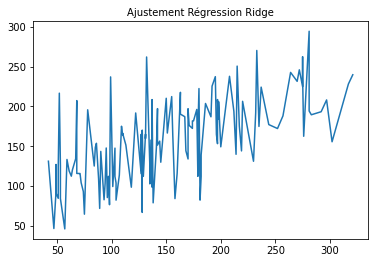

In [26]:
regridge(0)

k = 0.1

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.227098269942545
- MSE = 3050.0323833178904
- R2 = 0.4021292749449723


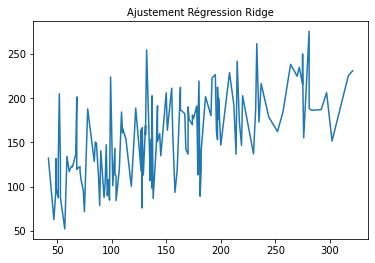

In [27]:
regridge(0.1)

k = 0.2

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.015159130262695
- MSE = 3026.667734128127
- R2 = 0.4067092393506434


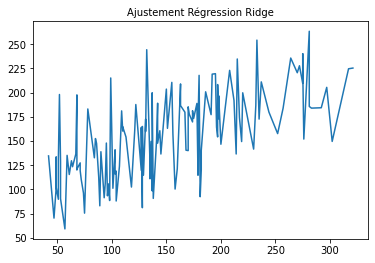

In [28]:
regridge(0.2)

k = 0.3

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.052105254959926
- MSE = 3030.734293003186
- R2 = 0.40591210797708555


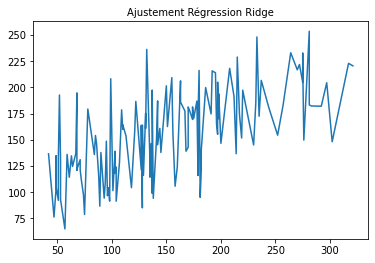

In [29]:
regridge(0.3)

k = 0.4

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.22012756388052
- MSE = 3049.262488171237
- R2 = 0.40228019064411824


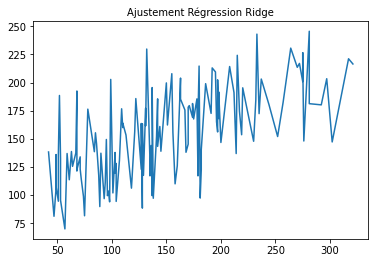

In [30]:
regridge(0.4)

In [31]:
# Liste des pickle des modèles sauvegardés sur le disque
%ls outputs/RegRidgeModele*.pkl -l

-rwxrwxrwx 1 root root 634 Oct 13 08:09 outputs/RegRidgeModele-k-0.1.pkl*
-rwxrwxrwx 1 root root 634 Oct 13 08:09 outputs/RegRidgeModele-k-0.2.pkl*
-rwxrwxrwx 1 root root 634 Oct 13 08:10 outputs/RegRidgeModele-k-0.3.pkl*
-rwxrwxrwx 1 root root 634 Oct 13 08:10 outputs/RegRidgeModele-k-0.4.pkl*
-rwxrwxrwx 1 root root 627 Oct 13 08:08 outputs/RegRidgeModele-k-0.pkl*


In [32]:
# Liste des graphiques sauvegardés sur le disque
%ls RegRidgeGraphique*.png -l

-rwxrwxrwx 1 root root 24473 Oct 13 08:09 RegRidgeGraphique-k-0.1.png*
-rwxrwxrwx 1 root root 26533 Oct 13 08:09 RegRidgeGraphique-k-0.2.png*
-rwxrwxrwx 1 root root 26879 Oct 13 08:10 RegRidgeGraphique-k-0.3.png*
-rwxrwxrwx 1 root root 27227 Oct 13 08:10 RegRidgeGraphique-k-0.4.png*
-rwxrwxrwx 1 root root 24998 Oct 13 08:09 RegRidgeGraphique-k-0.png*


## Référencement du modèle

Le meilleur modèle est pour k=0.2.

In [33]:
monmodele='RegRidgeModele-k-0.2.pkl'
k=0.2
RMSE = 55.015159130262695
MSE = 3026.667734128127
R2 = 0.4067092393506434

In [34]:
from azureml.core.model import Model

model = Model.register(model_path="outputs/"+monmodele, # Référence du pickle
                       model_name="DiabetesRidge", # Nom du modèle référencé
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework
                       model_framework_version='0.20.3',             # Version scikit-learn
                       tags={'area': 'Diabetes', # Ajout de tags au modèle
                             'type': 'Regression Ridge', 
                             'k':k, 
                             'MSE' : MSE, 
                             'R2' : R2,
                             'RMSE' : RMSE,
                             'Framework' : 'Azure ML SDK'},
                       description="Modèle de régression Ridge", # Description du modèle
                       workspace=ws) # Nom du workspace Azure ML

Registering model DiabetesRidge


Le modèle est référencé dans le référentiel des modèles Azure ML.

## Informations du modèle référencé

In [35]:
print('Nom du modèle :', model.name)
print('Description :', model.description)
print('ID =', model.id)
print('Version =', model.version)

Nom du modèle : DiabetesRidge
Description : Modèle de régression Ridge
ID = DiabetesRidge:2
Version = 2


Nous pouvons visualiser les résultats sur le portail dans la section **experiments** :

In [36]:
experiment

Name,Workspace,Report Page,Docs Page
Intro-AzureML,workshoplcl,Link to Azure Machine Learning studio,Link to Documentation


<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">